# Modelo de crédito 
## Este programa es un algoritmo de regresión logística para aprobar/rechazar aspirantes, de los cuales contamos con cierta información.

## El programa se divide en las siguientes partes
- Importado de las librerías necesarias y de los datos.
- Análisis exploratorio de datos.
- Limpieza de datos (proceso ETL)
- Entrenamiento de algoritmo
- Optimización de hiper-parámetros
- Visualización de resultados

## Importado de librerías y datos

#### Comenzamos importando las librerías necesarias

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#### También importamos los datos que utilizará nuestro modelo. Estos son dos bases de datos CSV en las cuales tenemos información de los aspirantes y su historial crediticio.

In [26]:
df_datos = pd.read_csv('C:/Users/Franc/Downloads/application_record.csv/application_record.csv', sep=',', header=0)
df_historial = pd.read_csv('C:/Users/Franc/Downloads/credit_record.csv/credit_record.csv', sep=',', header=0)

## Análisis exploratorio de datos y limpieza

#### Renombramos las columnas de nuestro Dataframe por cuestiones de claridad

In [28]:
df_datos.rename(columns={'CODE_GENDER':'Genero', 
                       'FLAG_OWN_CAR':'Auto', 
                       'FLAG_OWN_REALTY':'Auto propio', 
                       'CNT_CHILDREN':'Número de hijos', 
                      'AMT_INCOME_TOTAL':'Ingresos anuales',
                      'NAME_INCOME_TYPE': 'Fuente de ingresos',
                      'NAME_EDUCATION_TYPE':'Grado de estudios',
                      'NAME_FAMILY_STATUS':'Estado civil',
                      'NAME_HOUSING_TYPE':'Residencia',
                      'DAYS_BIRTH':'Edad en años',
                      'DAYS_EMPLOYED':'Años trabajados',
                      'FLAG_MOBIL':'Tel. Celular',
                      'FLAG_WORK_PHONE':'Tel. de trabajo',
                      'FLAG_PHONE':'Tel. fijo',
                      'FLAG_EMAIL':'Email',
                      'OCCUPATION_TYPE':'Ocupación',
                      'CNT_FAM_MEMBERS':'N. de miembros familiares',
                      'MONTHS_BALANCE':'Mes de balance',
                      'STATUS':'Estado de crédito'}, inplace=True)
df_datos.sample(5)

,ID,Genero,Auto,Auto propio,Número de hijos,Ingresos anuales,Fuente de ingresos,Grado de estudios,Estado civil,Residencia,Edad en años,Años trabajados,Tel. Celular,Tel. de trabajo,Tel. fijo,Email,Ocupación,N. de miembros familiares
25768,5087813,F,Y,Y,1,135000.0,Working,Secondary / secondary special,Separated,House / apartment,-11810,-648,1,1,1,0,Sales staff,2.0
100782,5416127,F,N,Y,0,146250.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-12830,-919,1,1,0,0,Sales staff,2.0
98043,5825775,M,N,Y,0,180000.0,Working,Incomplete higher,Married,House / apartment,-13146,-6301,1,1,0,0,Laborers,2.0
415886,6800720,M,N,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-17901,-1552,1,0,0,0,Core staff,2.0
178774,5833731,F,N,Y,0,337500.0,Commercial associate,Higher education,Single / not married,House / apartment,-8918,-505,1,0,0,0,NaN,1.0


#### Nos interesa conocer cuantas variables nulas existen, para eliminarlas o transformarlas en alguna información útil

In [30]:
df_datos.isnull().sum()

ID                                0
Genero                            0
Auto                              0
Auto propio                       0
Número de hijos                   0
Ingresos anuales                  0
Fuente de ingresos                0
Grado de estudios                 0
Estado civil                      0
Residencia                        0
Edad en años                      0
Años trabajados                   0
Tel. Celular                      0
Tel. de trabajo                   0
Tel. fijo                         0
Email                             0
Ocupación                    134203
N. de miembros familiares         0
dtype: int64

#### Vemos que tenemos 134203 valores nulos en la columna de ocupación. Vamos a eliminar esas variables nulas para quedarnos solo con información útil

In [32]:
df_datos=df_datos.dropna()
df_datos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304354 entries, 2 to 438556
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         304354 non-null  int64  
 1   Genero                     304354 non-null  object 
 2   Auto                       304354 non-null  object 
 3   Auto propio                304354 non-null  object 
 4   Número de hijos            304354 non-null  int64  
 5   Ingresos anuales           304354 non-null  float64
 6   Fuente de ingresos         304354 non-null  object 
 7   Grado de estudios          304354 non-null  object 
 8   Estado civil               304354 non-null  object 
 9   Residencia                 304354 non-null  object 
 10  Edad en años               304354 non-null  int64  
 11  Años trabajados            304354 non-null  int64  
 12  Tel. Celular               304354 non-null  int64  
 13  Tel. de trabajo            304354 

#### Ahora buscamos ID's duplicadas para conocer si tenemos filas de datos repetidos

In [34]:
df_datos.duplicated(subset=['ID']).sum()

23

#### Vemos que sí tenemos datos repetidos, procedemos a limpiarlos

In [36]:
df_datos.drop_duplicates(subset=['ID'], inplace=True)
df_datos.duplicated(subset=['ID']).sum()

0

#### Procedemos con la limpieza siguiente
- Transformar columnas de datos númericos a variables manejables.
- Transformar columnas de datos númericos en formato no útil a un formato más didactico

In [38]:
df_datos['Edad en años'] = pd.to_numeric(df_datos['Edad en años'], errors='coerce').astype('float64')
df_datos['Años trabajados'] = pd.to_numeric(df_datos['Años trabajados'], errors='coerce').astype('Int64')
df_datos['Edad en años'] = (df_datos['Edad en años'].apply(lambda row: (-1)*row//365))
df_datos['Años trabajados'] = (df_datos['Años trabajados'].apply(lambda row: -row//365 if pd.notnull(row) and row < 0 else 'Desempleado'))
df_datos.sample(5)

,ID,Genero,Auto,Auto propio,Número de hijos,Ingresos anuales,Fuente de ingresos,Grado de estudios,Estado civil,Residencia,Edad en años,Años trabajados,Tel. Celular,Tel. de trabajo,Tel. fijo,Email,Ocupación,N. de miembros familiares
423497,7295678,F,N,Y,0,157500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,63.0,9,1,0,0,0,Cleaning staff,2.0
234951,5998891,F,Y,Y,0,94500.0,Working,Secondary / secondary special,Married,House / apartment,54.0,6,1,0,0,0,Medicine staff,2.0
45618,5137206,M,N,N,0,90000.0,Working,Secondary / secondary special,Single / not married,With parents,27.0,0,1,1,0,0,Drivers,1.0
225801,5980288,F,Y,Y,1,450000.0,State servant,Higher education,Married,House / apartment,37.0,6,1,0,0,0,Accountants,3.0
108261,5454676,F,N,N,1,193500.0,State servant,Higher education,Married,House / apartment,27.0,4,1,0,0,0,Accountants,3.0


#### Ahora tenemos datos más manipulables. Nos interesa conocer cuantos posibles valores pueden tomar las diferentes variables strings o alfabeticas para ver que información rescatamos de ellas. También queremos conocer algunas columnas con variables númericas de valores discretos

#### Definimos la siguiente función la cual nos representa graficamente los valores que queremos conocer

In [40]:
def contador_de_datos(df, columnas, titles=None, max_cols=2):
    n = len(columnas)
    rows = (n + max_cols - 1) // max_cols

    plt.figure(figsize=(5 * max_cols, 4 * rows))

    for i, col in enumerate(columnas):
        plt.subplot(rows, max_cols, i + 1)
        sns.countplot(data=df, x=col, palette='pastel', order=df[col].value_counts().index)
        plt.title(titles[i] if titles else col)
        plt.xticks(rotation=45)
        plt.xlabel("")
        plt.ylabel("Count")

    plt.tight_layout()
    plt.suptitle("Distributions of Applicants", fontsize=16, y=1.02)
    plt.show()

#### Pasamos el argumento de la función la cual es una lista de las columnas del Dataframe

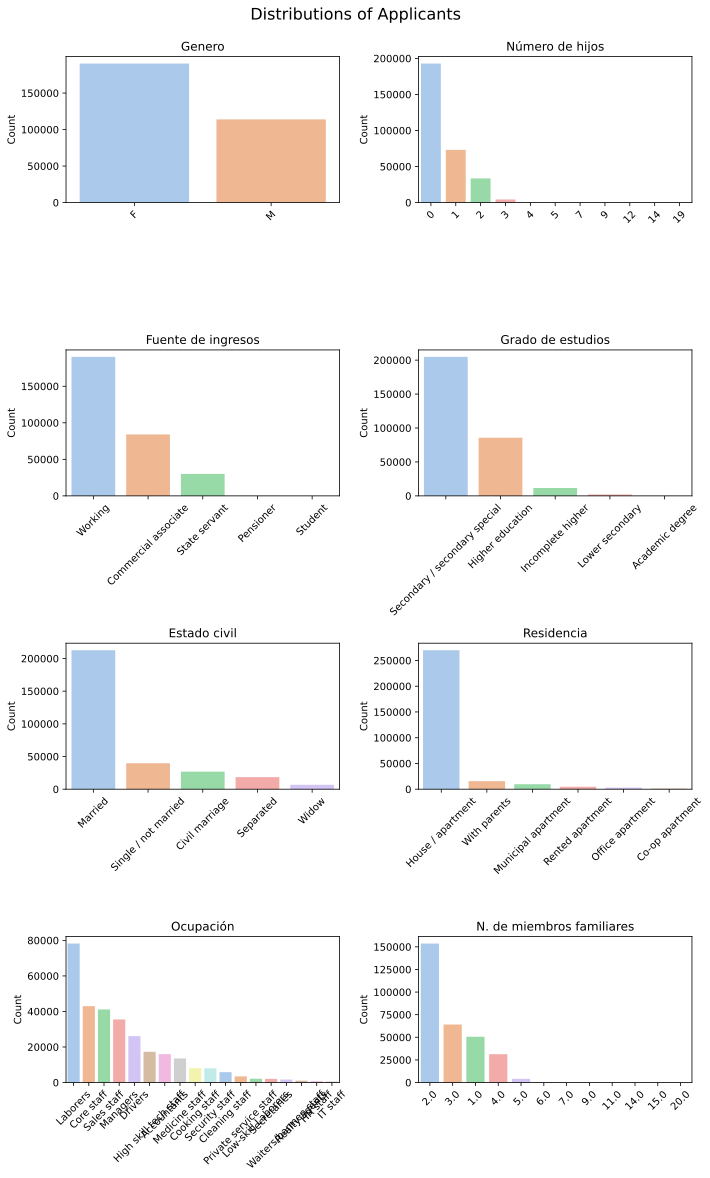

In [42]:
columnas=['Genero', 'Número de hijos', 'Fuente de ingresos', 'Grado de estudios', 'Estado civil', 'Residencia', 'Ocupación', 'N. de miembros familiares']
contador_de_datos(df_datos, columnas)

#### Nosotros sabemos de la naturaleza del Dataframe 'historial' que los valores para la columna 'STATUS' no son muchos, pero nos interesaremos en la cantidad que tienen estas variables

In [44]:
df_historial['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

#### De la descripción anterior, procedemos a calificar los status de aspirantes simplemente como 'Bueno' o 'Malo' dependiendo de cierto umbral

In [46]:
df_historial.rename(columns={'STATUS':'Historial crediticio'}, inplace=True)
df_historial['Historial crediticio'] = df_historial['Historial crediticio'].apply(lambda row: 'Bueno' if row=='X' or row=='C' else 'Malo')
df_historial.sample(5)

,ID,MONTHS_BALANCE,Historial crediticio
146724,5011732,-44,Bueno
42474,5003621,-21,Bueno
230691,5021739,-6,Bueno
850087,5118297,-46,Bueno
214628,5018173,-13,Bueno


#### Sabemos que el Dataframe 'historial' tiene valores de ID repetidos debido a que un mismo cliente puede tener varios movimientos a la hora de adeudar o saldar su crédito. Por lo tanto, agrupamos los historiales Buenos y Malos por ID en un nuevo Dataframe

In [48]:
estado_de_cuenta = df_historial.groupby('ID')['Historial crediticio'].value_counts().unstack(fill_value=0)
estado_de_cuenta.sample(5)

Historial crediticio,Bueno,Malo
ID,,
5137217,26,0
5122055,16,10
5046004,8,0
5002869,5,9
5042319,1,5


#### Ahora, para trabajar con un solo Dataframe, vamos a fusionar los dos con los que hemos trabajado usando de pivote la columna 'ID'

In [50]:
df_raw = df_datos.set_index('ID').join(estado_de_cuenta)
df_raw.sample(5)

,Genero,Auto,Auto propio,Número de hijos,Ingresos anuales,Fuente de ingresos,Grado de estudios,Estado civil,Residencia,Edad en años,Años trabajados,Tel. Celular,Tel. de trabajo,Tel. fijo,Email,Ocupación,N. de miembros familiares,Bueno,Malo
ID,,,,,,,,,,,,,,,,,,,
6484447,F,N,Y,0,202500.0,Commercial associate,Higher education,Civil marriage,House / apartment,28.0,2,1,0,0,0,Medicine staff,2.0,NaN,NaN
6604147,F,N,Y,1,157500.0,Working,Secondary / secondary special,Separated,House / apartment,41.0,6,1,0,0,0,Sales staff,2.0,NaN,NaN
5142720,F,N,N,0,202500.0,Working,Secondary / secondary special,Single / not married,House / apartment,56.0,35,1,1,0,0,Medicine staff,1.0,20.0,0.0
6089514,M,N,Y,0,225000.0,Commercial associate,Higher education,Single / not married,Office apartment,24.0,2,1,1,0,0,Laborers,1.0,NaN,NaN
6077690,M,Y,Y,1,180000.0,Working,Incomplete higher,Married,House / apartment,41.0,3,1,0,0,0,Laborers,3.0,NaN,NaN


#### Los aspirantes sin historial crediticio o con ID que no aparece en el Dataframe de historial, procedemos a rellenar sus datos vacíos con 0

#### Tambiénos interesa conocer cuantos aspirantes no tienen historial crediticio

In [52]:
df_raw[['Bueno', 'Malo']] = df_raw[['Bueno', 'Malo']].fillna(0)
((df_raw['Bueno'] == 0) & (df_raw['Malo'] == 0)).sum()

279197

#### Establecemos un umbral de salario para definir una nueva columna del Dataframe en el que catalogaremos el estado de cada aspirante.

#### Para hacerlo, estableceremos una función la cual realiza la siguiente operación
- Si el aspirante no tiene historial crediticio, revisa sus ingresos anuales.
- Si sus ingresos anuales superan cierto umbral su estado de aspirante es Bueno, si no lo supera su estado de aspirante es Malo
- Si el cliente cuenta con historial crediticio compara la cantidad de estados 'Bueno' y 'Malo', si tiene más buenos que malos, su estado de aspirante será bueno, de lo contrario será malo

In [54]:
umbral_de_salario = 75000
df_raw['Estado de aspirante'] = np.where((df_raw['Bueno'] == 0) & (df_raw['Malo'] == 0), np.where(df_raw['Ingresos anuales'] > umbral_de_salario, 'Bueno', 'Malo'), np.where(df_raw['Bueno'] > df_raw['Malo'], 'Bueno', 'Malo'))
df_raw.sample(5)

,Genero,Auto,Auto propio,Número de hijos,Ingresos anuales,Fuente de ingresos,Grado de estudios,Estado civil,Residencia,Edad en años,Años trabajados,Tel. Celular,Tel. de trabajo,Tel. fijo,Email,Ocupación,N. de miembros familiares,Bueno,Malo,Estado de aspirante
ID,,,,,,,,,,,,,,,,,,,,
6203094,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Married,Rented apartment,29.0,10,1,0,1,0,Laborers,2.0,0.0,0.0,Bueno
6640133,F,N,Y,0,202500.0,Working,Secondary / secondary special,Married,House / apartment,45.0,1,1,0,0,0,Cooking staff,2.0,0.0,0.0,Bueno
6239855,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,47.0,10,1,0,0,0,Sales staff,2.0,0.0,0.0,Bueno
5964368,F,Y,Y,1,123750.0,Working,Secondary / secondary special,Married,House / apartment,29.0,1,1,1,0,1,Sales staff,3.0,0.0,0.0,Bueno
6172894,F,N,N,0,112500.0,Working,Higher education,Single / not married,House / apartment,32.0,2,1,1,0,0,Laborers,1.0,0.0,0.0,Bueno


#### Obtenemos cuantos aspirantes tienen un estado Bueno y Malo

In [56]:
print(df_raw['Estado de aspirante'].value_counts())

Estado de aspirante
Bueno    283993
Malo      20338
Name: count, dtype: int64


#### Ahora, creamos el Dataframe con información útil que hemos obtenido y creamos una función que cataloga las variables textuales con valores discretos.

In [37]:
df = df_raw.copy()
cls = ['Genero', 'Auto', 'Fuente de ingresos', 'Grado de estudios', 'Estado civil', 'Residencia', 'Estado de aspirante']
for col in cls:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype('str'))
df.drop(columns=['Auto propio', 'Número de hijos', 'Ocupación', 'Bueno', 'Malo'], inplace=True)
df.sample(5)

,Genero,Auto,Ingresos anuales,Fuente de ingresos,Grado de estudios,Estado civil,Residencia,Edad en años,Años trabajados,Tel. Celular,Tel. de trabajo,Tel. fijo,Email,N. de miembros familiares,Estado de aspirante
ID,,,,,,,,,,,,,,,
6711327,0,0,225000.0,4,3,4,1,60.0,5,1,0,0,0,1.0,0
5632493,0,0,315000.0,0,4,0,1,51.0,14,1,0,1,0,2.0,0
6737929,0,0,90000.0,0,4,1,1,52.0,7,1,0,0,0,2.0,0
6650965,1,1,157500.0,0,1,1,1,37.0,10,1,0,0,1,2.0,0
5579287,1,1,382500.0,0,4,1,1,54.0,21,1,0,0,0,2.0,0


#### Ya tenemos Nuestro Dataframe con información que podemos usar para entrenar el modelo.
#### Podemos corroborar que esté correcto hasta este momento

In [39]:
df['Estado de aspirante'].value_counts()

Estado de aspirante
0    283993
1     20338
Name: count, dtype: int64

#### Creamos una matriz de correlación para cada variable y obtenemos lo siguiente

In [41]:
df.corr()

,Genero,Auto,Ingresos anuales,Fuente de ingresos,Grado de estudios,Estado civil,Residencia,Edad en años,Años trabajados,Tel. Celular,Tel. de trabajo,Tel. fijo,Email,N. de miembros familiares,Estado de aspirante
Genero,1.000000,0.331666,0.153764,0.015468,0.040543,-0.042518,0.046243,-0.106156,-0.106787,NaN,-0.016474,-0.027940,-0.003179,0.063062,-0.059572
Auto,0.331666,1.000000,0.173572,-0.018457,-0.073924,-0.089990,-0.011374,-0.067988,-0.042814,NaN,-0.035635,-0.010330,0.023780,0.114243,-0.046511
Ingresos anuales,0.153764,0.173572,1.000000,-0.154294,-0.207163,0.010583,-0.025421,0.063212,0.022082,NaN,-0.069974,0.005998,0.094298,-0.025198,-0.121331
Fuente de ingresos,0.015468,-0.018457,-0.154294,1.000000,0.128649,-0.000597,-0.001941,-0.008295,0.029638,NaN,0.072568,0.009653,-0.059678,0.025184,0.033239
Grado de estudios,0.040543,-0.073924,-0.207163,0.128649,1.000000,-0.026791,-0.008093,0.113432,0.033224,NaN,0.009291,-0.038072,-0.105867,0.005000,0.046149
Estado civil,-0.042518,-0.089990,0.010583,-0.000597,-0.026791,1.000000,0.064371,0.008263,-0.001176,NaN,-0.024406,-0.011805,0.006269,-0.515466,-0.006239
Residencia,0.046243,-0.011374,-0.025421,-0.001941,-0.008093,0.064371,1.000000,-0.201515,-0.087825,NaN,-0.000003,-0.028457,-0.000480,-0.031483,0.003989
Edad en años,-0.106156,-0.067988,0.063212,-0.008295,0.113432,0.008263,-0.201515,1.000000,0.347909,NaN,-0.038551,0.044887,-0.060175,-0.209090,-0.002069
Años trabajados,-0.106787,-0.042814,0.022082,0.029638,0.033224,-0.001176,-0.087825,0.347909,1.000000,NaN,0.011713,0.048645,-0.039559,-0.048772,-0.003070
Tel. Celular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Si queremos observarlo más claramente en un Heatmap

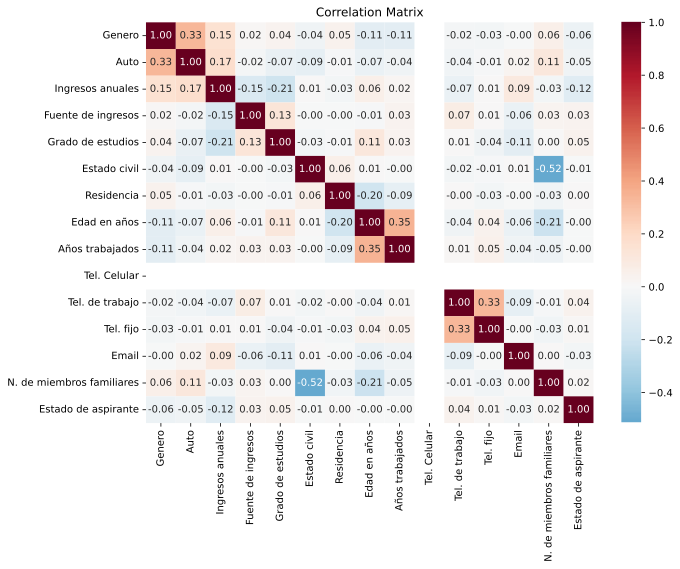

In [43]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df.corr(),
    annot=True,        
    fmt=".2f",         
    cmap="RdBu_r",     
    center=0           
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Entrenamiento de algoritmo

#### Ahora comenzamos a entrenar el modelo de regresión logística.
#### Entrenaremos el modelo usando las siguientes variables
- Género
- Auto
- Ingresos anuales
- Fuente de ingresos
- Grado de estudios
- Estado civil
- Residencia
- Edad
- Años trabajando
- Teléfono de trabajo
- Teléfono celular
- Teléfono fijo
- Email
- Número de miembros familiares
#### La variable de salida es el estado de aspirante. Usamos la función SMOTE para balancear los datos de entrenamiento

In [47]:
X = df[['Genero', 'Auto', 'Ingresos anuales', 'Fuente de ingresos', 'Grado de estudios', 'Estado civil', 'Residencia', 'Edad en años', 'Años trabajados', 'Tel. Celular', 'Tel. de trabajo', 'Tel. fijo', 'Email', 'N. de miembros familiares']]
y = df['Estado de aspirante']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(pd.Series(y_resampled.value_counts()))

Estado de aspirante
0    283993
1    283993
Name: count, dtype: int64


#### Alimentamos el modelo con los datos de entrenamiento en usando train_test_split y vemos el orden de magnitud entre el conjunto de test y el conjunto de datos de entrenamiento

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print('Set de prueba {}'.format(y_train.value_counts()))
print('Set de test {}'.format(y_test.value_counts()))

Set de prueba Estado de aspirante
0    227372
1    227016
Name: count, dtype: int64
Set de test Estado de aspirante
1    56977
0    56621
Name: count, dtype: int64


## Optimización de hiper-parámetros

#### Ahora comenzamos con la optimización de hiper-parámetros. Este paso no es obligatorio para obtener el modelo, pero vamos a realizarlo porque nos ofrece sacarle el máximo potencial y mejorar mucho la precisión. Usamos la librería Optuna para esto y un RandomForest. La función de optimización tendrá el siguiente aspecto

In [55]:
!pip install imblearn
!pip install optuna
import optuna
from sklearn.model_selection import cross_val_score
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
    }
    model = RandomForestClassifier(**params)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)       

print("Mejores parametros:", study.best_params)
print("F1:", study.best_value)

[I 2025-08-04 13:35:59,162] A new study created in memory with name: no-name-370a203d-ef84-4476-98ef-4fd537626d7c
[I 2025-08-04 13:37:52,419] Trial 0 finished with value: 0.8251649285087778 and parameters: {'n_estimators': 112, 'max_depth': 13, 'min_samples_split': 3}. Best is trial 0 with value: 0.8251649285087778.
[I 2025-08-04 13:38:09,423] Trial 1 finished with value: 0.9417204883059679 and parameters: {'n_estimators': 13, 'max_depth': 21, 'min_samples_split': 9}. Best is trial 1 with value: 0.9417204883059679.
[I 2025-08-04 13:40:33,019] Trial 2 finished with value: 0.9682358676857854 and parameters: {'n_estimators': 102, 'max_depth': 27, 'min_samples_split': 9}. Best is trial 2 with value: 0.9682358676857854.
[I 2025-08-04 13:42:41,972] Trial 3 finished with value: 0.9436848487391626 and parameters: {'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 9}. Best is trial 2 with value: 0.9682358676857854.
[I 2025-08-04 13:44:29,709] Trial 4 finished with value: 0.972519012349

Best parameters: {'n_estimators': 133, 'max_depth': 30, 'min_samples_split': 3}
F1 Score: 0.9735662421778554


#### Ya nos ha otorgado los mejores parámetros. Este método es más exigente computacionalmente pero lo compensa con la efectividad.

## Visualización de resultados

#### Finalmente, vamos a reportar los resultados del modelo usando el conjunto de datos de prueba. Creamos un gráfico de Matriz de confusión usando los datos de test y creamos un gráfico de barras el cual nos muestra cuales son las variables que tienen más relevancia en nuestro estudio.

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     56621
           1       0.97      0.98      0.98     56977

    accuracy                           0.98    113598
   macro avg       0.98      0.98      0.98    113598
weighted avg       0.98      0.98      0.98    113598



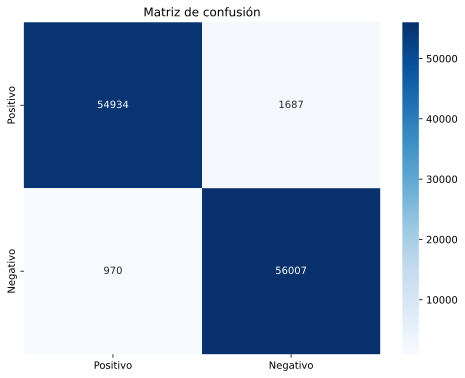

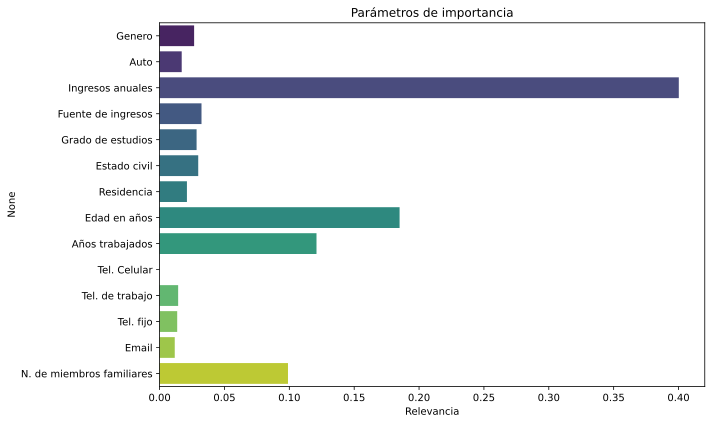

In [59]:
from sklearn.metrics import classification_report, confusion_matrix

best_rf_params = study.best_params
best_rf_params.update({'random_state': 42, 'n_jobs': -1})

rf_model = RandomForestClassifier(**best_rf_params)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]  

print("Classification Report:")
print(classification_report(y_test, y_pred))


plt.figure(figsize=(8, 6)) 
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positivo', 'Negativo'],
            yticklabels=['Positivo', 'Negativo'])
plt.title('Matriz de confusión')
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(x=rf_model.feature_importances_, y=X_train.columns, palette='viridis')
plt.title('Parámetros de importancia')
plt.xlabel('Relevancia')
plt.tight_layout()
plt.show()

#### De clasification report, obtenemos que el modelo tiene una precisión cercana al 98%, producto de la optimización de hiper-parámetros, además de que esto se mira reflejado en nuestra matriz de confusión.
#### El modelo ha aprobado un total de 54934 créditos, rechazado 56007 además de 1687 falsos negativos y 970 falsos positivos

#### Del gráfico de barras obtenemos que las 3 variables que más influyen a la horar de que el modelo apruebe un crédito o no es, en primer lugar por mucha diferencia de los ingresos anuales, en segundo la edad, y tercero de los años laborando que tiene una persona.
#### El número de miembros familiares también tiene cierta relevancia y el factor menos determinante es si la persona cuenta con una cuenta de correo electrónico.